In [1]:
LANGUAGE = 'bam'
EXPERIMENT = 'final_ground_truth_active_learning'
PREFERRED_GPU = 'cuda:4' # 'cuda:0'

In [2]:
# Prevent WandB from printing summary in cell output
%env WANDB_SILENT=true

env: WANDB_SILENT=true


In [3]:
import os
import sys
import yaml
import copy
import yaml
import wandb
import torch
import warnings

import torch.nn as nn
from torch.utils.data import DataLoader

from getpass import getpass
from tqdm.notebook import tqdm
from datasets import load_dataset
from sklearn.exceptions import UndefinedMetricWarning
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

torch.cuda.empty_cache()
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [4]:
# Add src module to system path
src_module_path = os.path.abspath('../../../')
if src_module_path not in sys.path:
    sys.path.append(src_module_path)

# Import functions and classes from custom modules
from src.data.preprocess import (
    align_labels_for_many_records,
    TorchDataset,
    balanced_split_for_active_learning
)

from src.utils.utils import (predict_sequence_max_uncertainty,
                             batch_indices_to_global_indices,
                             print_classification_report,
                             calculate_micro_f1_for_batches,
                             calculate_macro_f1_for_batches)
from src.models.xlmr_ner import XLMRobertaForNER

In [5]:
CONFIG_PATH = "../../../settings/config.yml"

In [6]:
# Reading config file
config = yaml.safe_load(open(CONFIG_PATH))

In [7]:
wandb.login(key=getpass("Weights and Biases API key:"))

True

In [8]:
label_mapping = config['label_mapping']
# Loading tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Initialize model
base_model = XLMRobertaForNER(model_name=config['model_name'], 
                         num_labels=len(config['label_mapping'].keys()))

# Choose a GPU to use
default_device = config['gpu_settings']['default_device'] if \
    PREFERRED_GPU=='' else PREFERRED_GPU

# Send model to GPU if cuda is available otherwise use CPU
device = torch.device(default_device if torch.cuda.is_available() else "cpu")
print(device)

base_model.to(device)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at Davlan/afro-xlmr-mini and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda:4


XLMRobertaForNER(
  (xlmr): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 384, padding_idx=1)
      (position_embeddings): Embedding(514, 384, padding_idx=1)
      (token_type_embeddings): Embedding(1, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
          

  0%|          | 0/3 [00:00<?, ?it/s]

Original dataset:
 DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4462
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 638
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1274
    })
})


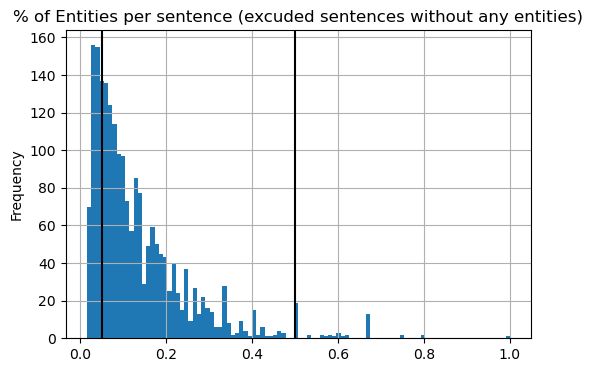

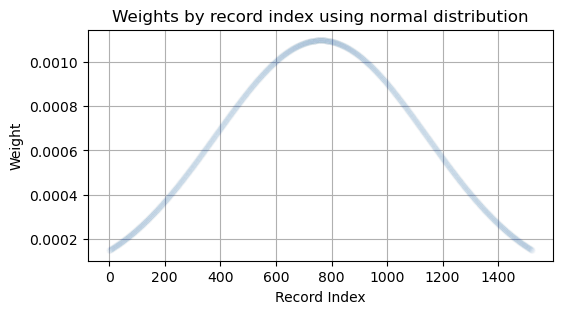

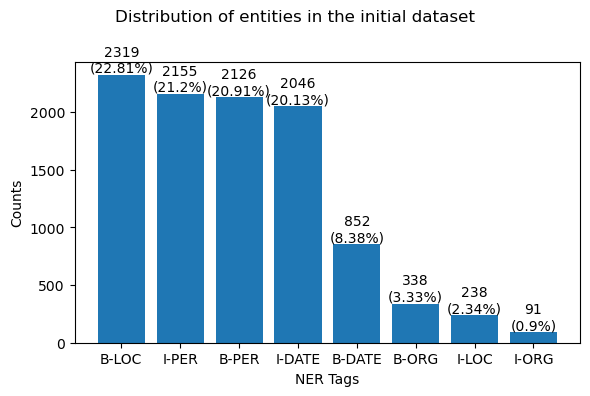

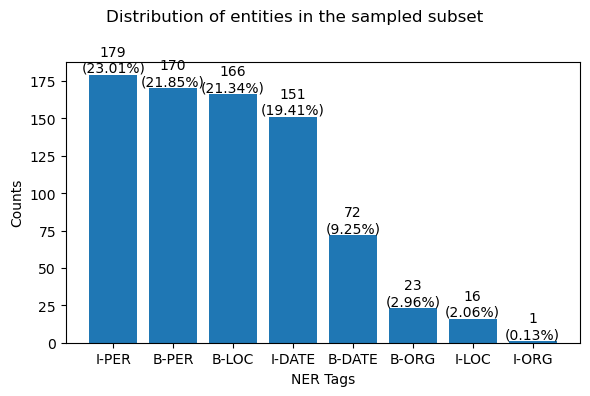

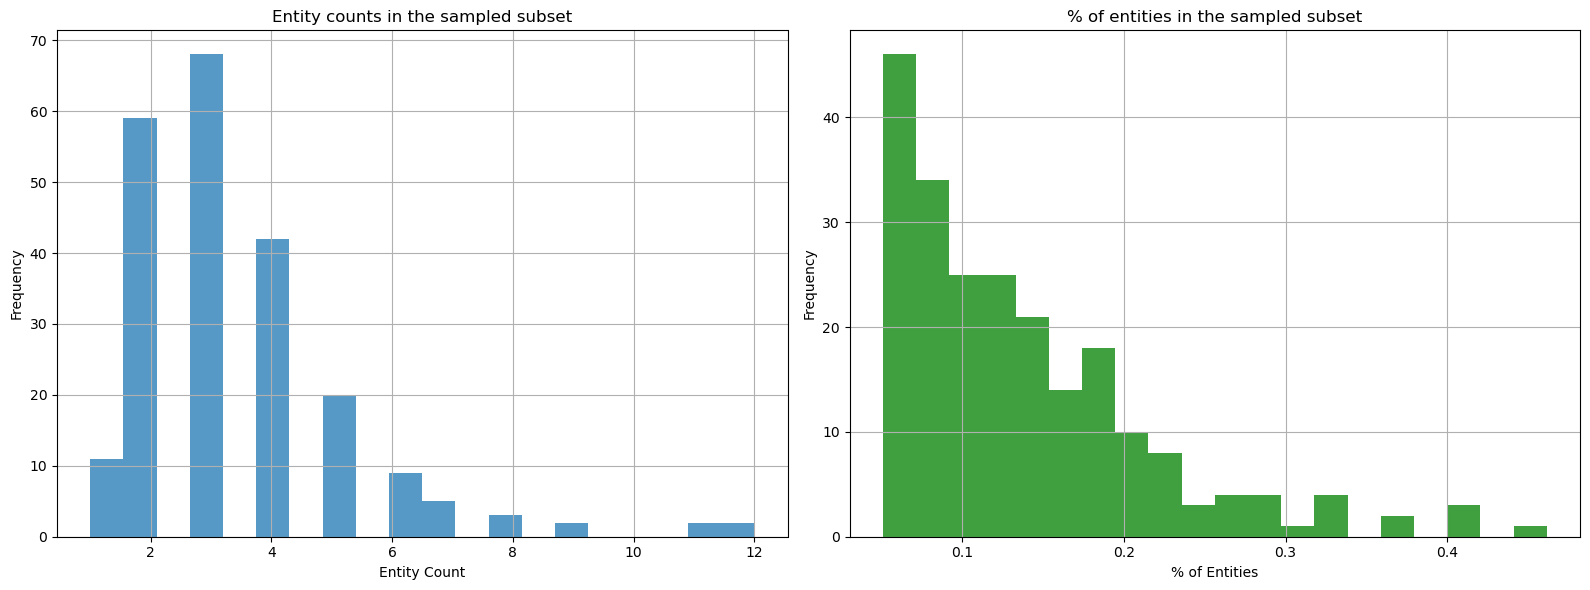

Filter:   0%|          | 0/4462 [00:00<?, ? examples/s]

Split the dataset into initial training (first 5.0%) and active learning (remaining 95.0%).
Overall training dataset size: 4462
Initial training dataset size: 223
Active learning dataset size: 4239


In [9]:
# Download dataset for the specific language 
data = load_dataset(config['dataset'], LANGUAGE)
print("Original dataset:\n", data)

# splitting the data for active learning integration
data = balanced_split_for_active_learning(
    data,
    label_mapping,
    train_key='train',
    split_ratio=config['train_settings']['initial_train_size'],
    verbose=True
)

In [10]:
data = data.map(
    align_labels_for_many_records,
    batched=True,
    fn_kwargs={'tokenizer': tokenizer}
)

Map:   0%|          | 0/4239 [00:00<?, ? examples/s]

In [11]:
# Settings
max_len = config['languages_max_tokens'][LANGUAGE]
print(f'Maximum token length for language {LANGUAGE} is {max_len}')
padding_val = config['tokenizer_settings']['padding_value']

# Convert the datasets.Dataset to a PyTorch Dataset
dataset_init = TorchDataset(data['initial_training'], max_length=max_len, padding_value=padding_val)
dataset_unlabeled = TorchDataset(data['active_learning'], max_length=max_len, padding_value=padding_val)
dataset_test = TorchDataset(data['test'], max_length=max_len, padding_value=padding_val)
dataset_val = TorchDataset(data['validation'],max_length=max_len, padding_value=padding_val)

Maximum token length for language bam is 164


In [12]:
# Settings
batch_size = config['train_settings']['batch_size']
shuffle = config['train_settings']['shuffle']

# Create PyTorch DataLoaders
dataloader_init = DataLoader(dataset_init,
                             batch_size=batch_size,
                             shuffle=shuffle) # Shuffle only training set
dataloader_unlabeled = DataLoader(dataset_unlabeled, batch_size=batch_size)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [13]:
def train_ner(model, train_loader, val_loader, device, epochs, lr, updated_dataset_size, num_warmup_steps=5):
    training_history = {
        "train_loss": [],
        "val_loss": [],
        "val_micro_f1": [],
        "val_macro_f1": []
    }
    # Convert lr to float
    lr = float(config['train_settings']['lr'])
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=num_warmup_steps,
                                                num_training_steps=total_steps)

    # Loss function
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    best_val_f1 = 0.0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} [Train]", leave=False):
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask=attention_mask)

            logits_reshaped = logits.view(-1, logits.size(-1))
            labels_reshaped = labels.view(-1)

            # Calculate loss
            loss = loss_fn(logits_reshaped, labels_reshaped)

            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{epochs} [Val]", leave=False):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                logits = model(input_ids, attention_mask=attention_mask)
                logits_reshaped = logits.view(-1, logits.size(-1))
                labels_reshaped = labels.view(-1)

                # Calculate loss
                loss = loss_fn(logits_reshaped, labels_reshaped)

                total_val_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)

                val_predictions.append(predictions.detach())
                val_labels.append(batch['labels'].detach())

        avg_val_loss = total_val_loss / len(val_loader)
        micro_f1 = calculate_micro_f1_for_batches(val_predictions, val_labels, ignore_class=0)
        macro_f1 = calculate_macro_f1_for_batches(val_predictions, val_labels, ignore_class=0)

        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {micro_f1:.4f}")

        # Update training history
        training_history["train_loss"].append(avg_train_loss)
        training_history["val_loss"].append(avg_val_loss)
        training_history["val_micro_f1"].append(micro_f1)
        training_history["val_macro_f1"].append(macro_f1)

        # WandB logger
        wandb.log({
            "train_loss": avg_train_loss,
            "val_loss": avg_val_loss,
            "val_micro_f1": micro_f1,
            "val_macro_f1": macro_f1,
            "updated_dataset_size": updated_dataset_size
        })

    return model, training_history

In [14]:
# Prepare WandB for initial training
wandb.init(
    project=f'{EXPERIMENT}_{LANGUAGE}',
    name=f'{LANGUAGE}_initial',
    config={
        'epochs': config['train_settings']['epochs'],
        'learning_rate': config['train_settings']['lr'],
        'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
    },
    settings=wandb.Settings(disable_job_creation=True)
)

# create a new model out of base model for re-training and prevent fine-tuning
base_model_for_train = copy.deepcopy(base_model)

# Initial model training
initial_model, history = train_ner(base_model_for_train,
                                   dataloader_init,
                                   dataloader_val,
                                   device,
                                   epochs=config['train_settings']['epochs'],
                                   lr=config['train_settings']['lr'],
                                   updated_dataset_size=len(dataset_init))

# Delete the model as it is no longer utilized.
del base_model_for_train

# Disable WandB logger
wandb.finish()

Epoch 1/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.9247 | Val Loss: 1.3550 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.2519 | Val Loss: 1.0590 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 1.0802 | Val Loss: 0.9759 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 1.0144 | Val Loss: 0.9257 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.9658 | Val Loss: 0.8809 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.9235 | Val Loss: 0.8401 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.8848 | Val Loss: 0.8020 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.8486 | Val Loss: 0.7661 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.8149 | Val Loss: 0.7324 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.7832 | Val Loss: 0.7006 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.7536 | Val Loss: 0.6708 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.7256 | Val Loss: 0.6428 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.6997 | Val Loss: 0.6165 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.6751 | Val Loss: 0.5920 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.6525 | Val Loss: 0.5691 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.6311 | Val Loss: 0.5478 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.6112 | Val Loss: 0.5280 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.5930 | Val Loss: 0.5097 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.5761 | Val Loss: 0.4925 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.5601 | Val Loss: 0.4766 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.5455 | Val Loss: 0.4619 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.5320 | Val Loss: 0.4482 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.5195 | Val Loss: 0.4356 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.5079 | Val Loss: 0.4239 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.4974 | Val Loss: 0.4131 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.4875 | Val Loss: 0.4031 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.4785 | Val Loss: 0.3939 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.4700 | Val Loss: 0.3854 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.4624 | Val Loss: 0.3775 | Val F1: 0.0000


Epoch 30/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.4553 | Val Loss: 0.3702 | Val F1: 0.0000


Epoch 31/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.4492 | Val Loss: 0.3636 | Val F1: 0.0000


Epoch 32/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.4429 | Val Loss: 0.3574 | Val F1: 0.0000


Epoch 33/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.4373 | Val Loss: 0.3518 | Val F1: 0.0000


Epoch 34/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.4325 | Val Loss: 0.3466 | Val F1: 0.0000


Epoch 35/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.4276 | Val Loss: 0.3419 | Val F1: 0.0000


Epoch 36/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.4235 | Val Loss: 0.3376 | Val F1: 0.0000


Epoch 37/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.4197 | Val Loss: 0.3336 | Val F1: 0.0000


Epoch 38/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.4162 | Val Loss: 0.3300 | Val F1: 0.0000


Epoch 39/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.4131 | Val Loss: 0.3268 | Val F1: 0.0000


Epoch 40/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.4101 | Val Loss: 0.3239 | Val F1: 0.0000


Epoch 41/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.4075 | Val Loss: 0.3214 | Val F1: 0.0000


Epoch 42/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.4056 | Val Loss: 0.3191 | Val F1: 0.0000


Epoch 43/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.4033 | Val Loss: 0.3170 | Val F1: 0.0000


Epoch 44/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.4015 | Val Loss: 0.3153 | Val F1: 0.0000


Epoch 45/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.4000 | Val Loss: 0.3139 | Val F1: 0.0000


Epoch 46/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.3990 | Val Loss: 0.3127 | Val F1: 0.0000


Epoch 47/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.3979 | Val Loss: 0.3118 | Val F1: 0.0000


Epoch 48/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.3971 | Val Loss: 0.3111 | Val F1: 0.0000


Epoch 49/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.3969 | Val Loss: 0.3107 | Val F1: 0.0000


Epoch 50/50 [Train]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.3966 | Val Loss: 0.3106 | Val F1: 0.0000


In [15]:
# Model evaluation before re-training
print_classification_report(config, initial_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00     459.0
       B-LOC       0.00      0.00      0.00    1313.0
       B-ORG       0.00      0.00      0.00     357.0
       B-PER       0.00      0.00      0.00    1156.0
      I-DATE       0.00      0.00      0.00     623.0
       I-LOC       0.00      0.00      0.00      95.0
       I-ORG       0.00      0.00      0.00      67.0
       I-PER       0.00      0.00      0.00    1067.0
           O       0.00      0.00      0.00       0.0

    accuracy                           0.00    5137.0
   macro avg       0.00      0.00      0.00    5137.0
weighted avg       0.00      0.00      0.00    5137.0



In [16]:
# Select initial model as best model for the first round of active learning
best_model = copy.deepcopy(initial_model)

# Delete the model as it is no longer utilized.
del initial_model

# Use initial dataset to be combined with re-annotated uncertain samples for first round of active learning 
combined_dataset = copy.deepcopy(dataset_init)

# create a copy of active learning set and its ids to exclude last round samples easier duing active learning
active_learning_set = data['active_learning']

# Active learning framework
for round in range(config['active_learning_settings']['num_rounds']):
    print(10*"=" + f" Active Learning - Round {round+1} " + 10*"=")
    # Prepare WandB for active learning
    wandb.init(
        project=f'{EXPERIMENT}_{LANGUAGE}',
        name=f'{LANGUAGE}_round_{round+1}',
        config={
            'epochs': config['train_settings']['epochs'],
            'learning_rate': config['train_settings']['lr'],
            'num_active_learning_rounds': config['active_learning_settings']['num_rounds']
        },
        settings=wandb.Settings(disable_job_creation=True)
    )

    uncertain_samples = predict_sequence_max_uncertainty(
        best_model,
        dataloader_unlabeled,
        device,
        fraction=config['train_settings']['label_fraction']
    )

    # Delete the model as it is no longer utilized.
    del best_model

    global_indices = batch_indices_to_global_indices(uncertain_samples,
                                                    batch_size)

    # Create a subset from the pseudo-unlabeled data
    dataset_tune = data['active_learning'].select(global_indices)

    # Convert datasets.dataset to PyTorch dataset
    converted_dataset_tune = TorchDataset(dataset_tune,
                                        max_length=max_len,
                                        padding_value=padding_val)

    # Combine previous training data with newly labeled data
    combined_dataset = torch.utils.data.ConcatDataset([combined_dataset,
                                                    converted_dataset_tune])
    print("Size of updated re-training dataset: ", len(combined_dataset))

    # Create dataloader
    dataloader_tune = DataLoader(combined_dataset, batch_size=batch_size)

    # create a new model out of base model for re-training and prevent fine-tuning
    base_model_for_train = copy.deepcopy(base_model)

    # Re-train the model
    best_model, history = train_ner(base_model_for_train,
                                    dataloader_tune,
                                    dataloader_val,
                                    device,
                                    epochs=config['train_settings']['epochs'],
                                    lr=config['train_settings']['lr'],
                                    updated_dataset_size=len(combined_dataset))
    
    # Delete the model as it is no longer utilized.
    del base_model_for_train

    # Model evaluation after each round of active learning
    print_classification_report(config, best_model, dataloader_test, device, ignore_index=-100, ignore_class=0)

    # Disable WandB logger
    wandb.finish()

========== Active Learning - Round 1 ==========
Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  434


Epoch 1/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.6117 | Val Loss: 1.0722 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0504 | Val Loss: 0.9246 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.9396 | Val Loss: 0.8335 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.8566 | Val Loss: 0.7543 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7838 | Val Loss: 0.6833 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.7184 | Val Loss: 0.6196 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.6601 | Val Loss: 0.5627 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.6087 | Val Loss: 0.5127 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5636 | Val Loss: 0.4690 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.5246 | Val Loss: 0.4311 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4911 | Val Loss: 0.3986 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.4624 | Val Loss: 0.3706 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.4379 | Val Loss: 0.3466 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.4171 | Val Loss: 0.3260 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3994 | Val Loss: 0.3085 | Val F1: 0.0000


Epoch 16/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3844 | Val Loss: 0.2934 | Val F1: 0.0000


Epoch 17/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3716 | Val Loss: 0.2804 | Val F1: 0.0000


Epoch 18/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.3607 | Val Loss: 0.2692 | Val F1: 0.0000


Epoch 19/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.3513 | Val Loss: 0.2595 | Val F1: 0.0000


Epoch 20/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.3434 | Val Loss: 0.2512 | Val F1: 0.0000


Epoch 21/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.3365 | Val Loss: 0.2439 | Val F1: 0.0000


Epoch 22/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.3306 | Val Loss: 0.2375 | Val F1: 0.0000


Epoch 23/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.3254 | Val Loss: 0.2320 | Val F1: 0.0000


Epoch 24/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.3210 | Val Loss: 0.2271 | Val F1: 0.0000


Epoch 25/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.3171 | Val Loss: 0.2228 | Val F1: 0.0000


Epoch 26/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.3138 | Val Loss: 0.2191 | Val F1: 0.0000


Epoch 27/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.3108 | Val Loss: 0.2157 | Val F1: 0.0000


Epoch 28/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.3082 | Val Loss: 0.2128 | Val F1: 0.0000


Epoch 29/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.3058 | Val Loss: 0.2101 | Val F1: 0.0000


Epoch 30/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.3037 | Val Loss: 0.2077 | Val F1: 0.0000


Epoch 31/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.3017 | Val Loss: 0.2053 | Val F1: 0.0000


Epoch 32/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.2995 | Val Loss: 0.2028 | Val F1: 0.0000


Epoch 33/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.2964 | Val Loss: 0.2005 | Val F1: 0.0000


Epoch 34/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.2908 | Val Loss: 0.2244 | Val F1: 0.0034


Epoch 35/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.2895 | Val Loss: 0.1866 | Val F1: 0.0000


Epoch 36/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.2543 | Val Loss: 0.1708 | Val F1: 0.0000


Epoch 37/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.2368 | Val Loss: 0.1648 | Val F1: 0.0000


Epoch 38/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.2276 | Val Loss: 0.1591 | Val F1: 0.0182


Epoch 39/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.2176 | Val Loss: 0.1559 | Val F1: 0.1676


Epoch 40/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.2106 | Val Loss: 0.1543 | Val F1: 0.1813


Epoch 41/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.2042 | Val Loss: 0.1480 | Val F1: 0.1695


Epoch 42/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.1947 | Val Loss: 0.1438 | Val F1: 0.1824


Epoch 43/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.1899 | Val Loss: 0.1407 | Val F1: 0.1604


Epoch 44/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.1885 | Val Loss: 0.1395 | Val F1: 0.1710


Epoch 45/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.1862 | Val Loss: 0.1426 | Val F1: 0.1828


Epoch 46/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.1828 | Val Loss: 0.1466 | Val F1: 0.1900


Epoch 47/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.1797 | Val Loss: 0.1424 | Val F1: 0.1870


Epoch 48/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.1769 | Val Loss: 0.1421 | Val F1: 0.1900


Epoch 49/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.1773 | Val Loss: 0.1414 | Val F1: 0.1893


Epoch 50/50 [Train]:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.1773 | Val Loss: 0.1405 | Val F1: 0.1893


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.00      0.00      0.00       459
       B-LOC       0.73      0.01      0.02      1313
       B-ORG       0.00      0.00      0.00       357
       B-PER       0.69      0.01      0.02      1156
      I-DATE       0.00      0.00      0.00       623
       I-LOC       0.00      0.00      0.00        95
       I-ORG       0.00      0.00      0.00        67
       I-PER       0.24      0.93      0.38      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.20      5137
   macro avg       0.18      0.11      0.05      5137
weighted avg       0.39      0.20      0.09      5137

========== Active Learning - Round 2 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  645


Epoch 1/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4760 | Val Loss: 0.9827 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 1.0136 | Val Loss: 0.8411 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8947 | Val Loss: 0.7266 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.7969 | Val Loss: 0.6279 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.7143 | Val Loss: 0.5444 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6462 | Val Loss: 0.4756 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.5914 | Val Loss: 0.4199 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.5482 | Val Loss: 0.3753 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5146 | Val Loss: 0.3400 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4888 | Val Loss: 0.3121 | Val F1: 0.0000


Epoch 11/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.4690 | Val Loss: 0.2899 | Val F1: 0.0000


Epoch 12/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.4538 | Val Loss: 0.2724 | Val F1: 0.0000


Epoch 13/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.4418 | Val Loss: 0.2584 | Val F1: 0.0000


Epoch 14/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.4301 | Val Loss: 0.2509 | Val F1: 0.0000


Epoch 15/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.3781 | Val Loss: 0.2143 | Val F1: 0.0289


Epoch 16/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.3339 | Val Loss: 0.1936 | Val F1: 0.1821


Epoch 17/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.3087 | Val Loss: 0.1757 | Val F1: 0.1448


Epoch 18/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.2895 | Val Loss: 0.1611 | Val F1: 0.1870


Epoch 19/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.2634 | Val Loss: 0.1549 | Val F1: 0.1919


Epoch 20/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.2413 | Val Loss: 0.1441 | Val F1: 0.3025


Epoch 21/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.2212 | Val Loss: 0.1268 | Val F1: 0.4588


Epoch 22/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.2030 | Val Loss: 0.1182 | Val F1: 0.5542


Epoch 23/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1862 | Val Loss: 0.1115 | Val F1: 0.6351


Epoch 24/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1740 | Val Loss: 0.1080 | Val F1: 0.6575


Epoch 25/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.1616 | Val Loss: 0.0974 | Val F1: 0.6803


Epoch 26/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.1527 | Val Loss: 0.0944 | Val F1: 0.6956


Epoch 27/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.1442 | Val Loss: 0.0903 | Val F1: 0.7149


Epoch 28/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.1377 | Val Loss: 0.0877 | Val F1: 0.7495


Epoch 29/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.1316 | Val Loss: 0.0854 | Val F1: 0.7693


Epoch 30/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.1251 | Val Loss: 0.0793 | Val F1: 0.7830


Epoch 31/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.1203 | Val Loss: 0.0772 | Val F1: 0.7986


Epoch 32/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.1153 | Val Loss: 0.0738 | Val F1: 0.7997


Epoch 33/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.1121 | Val Loss: 0.0747 | Val F1: 0.8130


Epoch 34/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.1087 | Val Loss: 0.0719 | Val F1: 0.8065


Epoch 35/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.1054 | Val Loss: 0.0720 | Val F1: 0.8157


Epoch 36/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.1026 | Val Loss: 0.0698 | Val F1: 0.8141


Epoch 37/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0998 | Val Loss: 0.0737 | Val F1: 0.8198


Epoch 38/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0986 | Val Loss: 0.0703 | Val F1: 0.8164


Epoch 39/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0959 | Val Loss: 0.0704 | Val F1: 0.8160


Epoch 40/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0936 | Val Loss: 0.0710 | Val F1: 0.8210


Epoch 41/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0916 | Val Loss: 0.0728 | Val F1: 0.8252


Epoch 42/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0901 | Val Loss: 0.0703 | Val F1: 0.8236


Epoch 43/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0882 | Val Loss: 0.0698 | Val F1: 0.8274


Epoch 44/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0874 | Val Loss: 0.0682 | Val F1: 0.8305


Epoch 45/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0872 | Val Loss: 0.0677 | Val F1: 0.8271


Epoch 46/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0854 | Val Loss: 0.0664 | Val F1: 0.8271


Epoch 47/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0852 | Val Loss: 0.0657 | Val F1: 0.8267


Epoch 48/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0848 | Val Loss: 0.0648 | Val F1: 0.8290


Epoch 49/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0837 | Val Loss: 0.0647 | Val F1: 0.8290


Epoch 50/50 [Train]:   0%|          | 0/41 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0838 | Val Loss: 0.0648 | Val F1: 0.8290


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.88      0.82      0.85       459
       B-LOC       0.72      0.76      0.74      1313
       B-ORG       0.00      0.00      0.00       357
       B-PER       0.81      0.80      0.81      1156
      I-DATE       0.92      0.85      0.88       623
       I-LOC       0.00      0.00      0.00        95
       I-ORG       0.00      0.00      0.00        67
       I-PER       0.90      0.93      0.92      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.74      5137
   macro avg       0.47      0.46      0.47      5137
weighted avg       0.74      0.74      0.74      5137

========== Active Learning - Round 3 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  856


Epoch 1/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.4002 | Val Loss: 0.9332 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9824 | Val Loss: 0.7672 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8480 | Val Loss: 0.6320 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.7417 | Val Loss: 0.5239 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.6604 | Val Loss: 0.4408 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.6008 | Val Loss: 0.3792 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.5588 | Val Loss: 0.3345 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.5295 | Val Loss: 0.3025 | Val F1: 0.0000


Epoch 9/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.5076 | Val Loss: 0.2871 | Val F1: 0.0000


Epoch 10/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.4358 | Val Loss: 0.2332 | Val F1: 0.1798


Epoch 11/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.3658 | Val Loss: 0.1926 | Val F1: 0.1790


Epoch 12/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.3146 | Val Loss: 0.1695 | Val F1: 0.2056


Epoch 13/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.2792 | Val Loss: 0.1505 | Val F1: 0.5059


Epoch 14/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.2427 | Val Loss: 0.1291 | Val F1: 0.6237


Epoch 15/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.2166 | Val Loss: 0.1098 | Val F1: 0.6670


Epoch 16/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1894 | Val Loss: 0.1027 | Val F1: 0.7514


Epoch 17/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1728 | Val Loss: 0.0904 | Val F1: 0.7761


Epoch 18/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1569 | Val Loss: 0.0938 | Val F1: 0.8202


Epoch 19/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.1432 | Val Loss: 0.0885 | Val F1: 0.8320


Epoch 20/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.1312 | Val Loss: 0.0813 | Val F1: 0.8339


Epoch 21/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.1220 | Val Loss: 0.0703 | Val F1: 0.8301


Epoch 22/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.1141 | Val Loss: 0.0671 | Val F1: 0.8381


Epoch 23/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.1076 | Val Loss: 0.0701 | Val F1: 0.8495


Epoch 24/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.1011 | Val Loss: 0.0712 | Val F1: 0.8594


Epoch 25/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0963 | Val Loss: 0.0678 | Val F1: 0.8620


Epoch 26/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0908 | Val Loss: 0.0685 | Val F1: 0.8643


Epoch 27/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0864 | Val Loss: 0.0626 | Val F1: 0.8624


Epoch 28/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0819 | Val Loss: 0.0602 | Val F1: 0.8662


Epoch 29/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0772 | Val Loss: 0.0566 | Val F1: 0.8616


Epoch 30/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0740 | Val Loss: 0.0542 | Val F1: 0.8674


Epoch 31/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0716 | Val Loss: 0.0546 | Val F1: 0.8742


Epoch 32/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0692 | Val Loss: 0.0528 | Val F1: 0.8715


Epoch 33/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0667 | Val Loss: 0.0499 | Val F1: 0.8643


Epoch 34/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0644 | Val Loss: 0.0474 | Val F1: 0.8571


Epoch 35/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0629 | Val Loss: 0.0513 | Val F1: 0.8708


Epoch 36/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0603 | Val Loss: 0.0475 | Val F1: 0.8658


Epoch 37/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0585 | Val Loss: 0.0471 | Val F1: 0.8662


Epoch 38/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0575 | Val Loss: 0.0462 | Val F1: 0.8689


Epoch 39/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0565 | Val Loss: 0.0464 | Val F1: 0.8712


Epoch 40/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0546 | Val Loss: 0.0458 | Val F1: 0.8677


Epoch 41/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0538 | Val Loss: 0.0462 | Val F1: 0.8719


Epoch 42/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0530 | Val Loss: 0.0460 | Val F1: 0.8731


Epoch 43/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0522 | Val Loss: 0.0456 | Val F1: 0.8727


Epoch 44/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0514 | Val Loss: 0.0444 | Val F1: 0.8655


Epoch 45/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0511 | Val Loss: 0.0454 | Val F1: 0.8723


Epoch 46/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0505 | Val Loss: 0.0454 | Val F1: 0.8689


Epoch 47/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0501 | Val Loss: 0.0451 | Val F1: 0.8696


Epoch 48/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0495 | Val Loss: 0.0445 | Val F1: 0.8704


Epoch 49/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0490 | Val Loss: 0.0450 | Val F1: 0.8723


Epoch 50/50 [Train]:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0494 | Val Loss: 0.0449 | Val F1: 0.8712


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.95      0.90      0.92       459
       B-LOC       0.88      0.76      0.81      1313
       B-ORG       0.85      0.78      0.81       357
       B-PER       0.89      0.81      0.85      1156
      I-DATE       0.95      0.90      0.93       623
       I-LOC       0.42      0.24      0.31        95
       I-ORG       0.00      0.00      0.00        67
       I-PER       0.92      0.93      0.92      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.82      5137
   macro avg       0.65      0.59      0.62      5137
weighted avg       0.88      0.82      0.85      5137

========== Active Learning - Round 4 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  1067


Epoch 1/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3457 | Val Loss: 0.8908 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9476 | Val Loss: 0.6994 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.8009 | Val Loss: 0.5513 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6939 | Val Loss: 0.4430 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.6213 | Val Loss: 0.3682 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5747 | Val Loss: 0.3183 | Val F1: 0.0000


Epoch 7/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.5341 | Val Loss: 0.2732 | Val F1: 0.0000


Epoch 8/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.4426 | Val Loss: 0.2301 | Val F1: 0.1843


Epoch 9/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.3742 | Val Loss: 0.1904 | Val F1: 0.1904


Epoch 10/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.3340 | Val Loss: 0.1601 | Val F1: 0.4101


Epoch 11/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.2705 | Val Loss: 0.1256 | Val F1: 0.6834


Epoch 12/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.2167 | Val Loss: 0.1105 | Val F1: 0.7944


Epoch 13/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1840 | Val Loss: 0.0988 | Val F1: 0.8065


Epoch 14/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1606 | Val Loss: 0.0831 | Val F1: 0.8229


Epoch 15/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1434 | Val Loss: 0.0766 | Val F1: 0.8267


Epoch 16/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.1322 | Val Loss: 0.0715 | Val F1: 0.8472


Epoch 17/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.1192 | Val Loss: 0.0666 | Val F1: 0.8529


Epoch 18/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.1098 | Val Loss: 0.0623 | Val F1: 0.8468


Epoch 19/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0999 | Val Loss: 0.0591 | Val F1: 0.8544


Epoch 20/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0903 | Val Loss: 0.0533 | Val F1: 0.8442


Epoch 21/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0824 | Val Loss: 0.0518 | Val F1: 0.8662


Epoch 22/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0757 | Val Loss: 0.0525 | Val F1: 0.8700


Epoch 23/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0699 | Val Loss: 0.0493 | Val F1: 0.8639


Epoch 24/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0654 | Val Loss: 0.0463 | Val F1: 0.8628


Epoch 25/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0610 | Val Loss: 0.0467 | Val F1: 0.8681


Epoch 26/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0583 | Val Loss: 0.0453 | Val F1: 0.8674


Epoch 27/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0554 | Val Loss: 0.0451 | Val F1: 0.8746


Epoch 28/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0520 | Val Loss: 0.0426 | Val F1: 0.8788


Epoch 29/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0495 | Val Loss: 0.0441 | Val F1: 0.8742


Epoch 30/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0473 | Val Loss: 0.0419 | Val F1: 0.8750


Epoch 31/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0451 | Val Loss: 0.0406 | Val F1: 0.8757


Epoch 32/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0439 | Val Loss: 0.0407 | Val F1: 0.8731


Epoch 33/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0418 | Val Loss: 0.0413 | Val F1: 0.8769


Epoch 34/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0403 | Val Loss: 0.0407 | Val F1: 0.8784


Epoch 35/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0391 | Val Loss: 0.0387 | Val F1: 0.8723


Epoch 36/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0375 | Val Loss: 0.0385 | Val F1: 0.8605


Epoch 37/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0362 | Val Loss: 0.0411 | Val F1: 0.8852


Epoch 38/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0353 | Val Loss: 0.0398 | Val F1: 0.8757


Epoch 39/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0335 | Val Loss: 0.0376 | Val F1: 0.8776


Epoch 40/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0325 | Val Loss: 0.0369 | Val F1: 0.8681


Epoch 41/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0318 | Val Loss: 0.0369 | Val F1: 0.8723


Epoch 42/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0310 | Val Loss: 0.0369 | Val F1: 0.8670


Epoch 43/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0308 | Val Loss: 0.0383 | Val F1: 0.8845


Epoch 44/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0300 | Val Loss: 0.0367 | Val F1: 0.8757


Epoch 45/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0294 | Val Loss: 0.0363 | Val F1: 0.8757


Epoch 46/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0288 | Val Loss: 0.0357 | Val F1: 0.8719


Epoch 47/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0288 | Val Loss: 0.0362 | Val F1: 0.8750


Epoch 48/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0286 | Val Loss: 0.0370 | Val F1: 0.8788


Epoch 49/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0283 | Val Loss: 0.0359 | Val F1: 0.8723


Epoch 50/50 [Train]:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0282 | Val Loss: 0.0361 | Val F1: 0.8731


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.97      0.90      0.93       459
       B-LOC       0.91      0.76      0.83      1313
       B-ORG       0.80      0.79      0.80       357
       B-PER       0.91      0.83      0.87      1156
      I-DATE       0.95      0.92      0.94       623
       I-LOC       0.26      0.24      0.25        95
       I-ORG       0.60      0.40      0.48        67
       I-PER       0.95      0.90      0.92      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.82      5137
   macro avg       0.71      0.64      0.67      5137
weighted avg       0.91      0.82      0.86      5137

========== Active Learning - Round 5 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  1278


Epoch 1/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.3054 | Val Loss: 0.8505 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.9124 | Val Loss: 0.6363 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.7577 | Val Loss: 0.4824 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6562 | Val Loss: 0.3810 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.5956 | Val Loss: 0.3185 | Val F1: 0.0000


Epoch 6/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.5080 | Val Loss: 0.2518 | Val F1: 0.1916


Epoch 7/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.4119 | Val Loss: 0.2007 | Val F1: 0.1874


Epoch 8/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.3434 | Val Loss: 0.1599 | Val F1: 0.4356


Epoch 9/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.2723 | Val Loss: 0.1274 | Val F1: 0.6838


Epoch 10/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.2162 | Val Loss: 0.1102 | Val F1: 0.7929


Epoch 11/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1840 | Val Loss: 0.0911 | Val F1: 0.8252


Epoch 12/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1545 | Val Loss: 0.0766 | Val F1: 0.8290


Epoch 13/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.1355 | Val Loss: 0.0695 | Val F1: 0.8502


Epoch 14/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.1195 | Val Loss: 0.0641 | Val F1: 0.8328


Epoch 15/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.1046 | Val Loss: 0.0614 | Val F1: 0.8468


Epoch 16/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0925 | Val Loss: 0.0571 | Val F1: 0.8563


Epoch 17/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0820 | Val Loss: 0.0545 | Val F1: 0.8552


Epoch 18/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0743 | Val Loss: 0.0515 | Val F1: 0.8578


Epoch 19/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0685 | Val Loss: 0.0511 | Val F1: 0.8586


Epoch 20/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0633 | Val Loss: 0.0479 | Val F1: 0.8708


Epoch 21/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0580 | Val Loss: 0.0459 | Val F1: 0.8590


Epoch 22/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0538 | Val Loss: 0.0447 | Val F1: 0.8563


Epoch 23/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0499 | Val Loss: 0.0412 | Val F1: 0.8715


Epoch 24/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0470 | Val Loss: 0.0405 | Val F1: 0.8723


Epoch 25/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0435 | Val Loss: 0.0404 | Val F1: 0.8696


Epoch 26/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0410 | Val Loss: 0.0393 | Val F1: 0.8632


Epoch 27/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0386 | Val Loss: 0.0386 | Val F1: 0.8567


Epoch 28/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0363 | Val Loss: 0.0393 | Val F1: 0.8658


Epoch 29/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0338 | Val Loss: 0.0403 | Val F1: 0.8727


Epoch 30/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0324 | Val Loss: 0.0389 | Val F1: 0.8521


Epoch 31/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0302 | Val Loss: 0.0373 | Val F1: 0.8601


Epoch 32/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0291 | Val Loss: 0.0376 | Val F1: 0.8731


Epoch 33/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0274 | Val Loss: 0.0357 | Val F1: 0.8666


Epoch 34/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0267 | Val Loss: 0.0360 | Val F1: 0.8635


Epoch 35/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0254 | Val Loss: 0.0368 | Val F1: 0.8765


Epoch 36/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0241 | Val Loss: 0.0364 | Val F1: 0.8662


Epoch 37/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0229 | Val Loss: 0.0360 | Val F1: 0.8719


Epoch 38/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0221 | Val Loss: 0.0363 | Val F1: 0.8628


Epoch 39/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0217 | Val Loss: 0.0355 | Val F1: 0.8700


Epoch 40/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0209 | Val Loss: 0.0360 | Val F1: 0.8597


Epoch 41/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0206 | Val Loss: 0.0358 | Val F1: 0.8814


Epoch 42/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0204 | Val Loss: 0.0362 | Val F1: 0.8693


Epoch 43/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0196 | Val Loss: 0.0364 | Val F1: 0.8651


Epoch 44/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0196 | Val Loss: 0.0352 | Val F1: 0.8662


Epoch 45/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0189 | Val Loss: 0.0360 | Val F1: 0.8670


Epoch 46/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0191 | Val Loss: 0.0353 | Val F1: 0.8708


Epoch 47/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0183 | Val Loss: 0.0356 | Val F1: 0.8662


Epoch 48/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0183 | Val Loss: 0.0361 | Val F1: 0.8681


Epoch 49/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0181 | Val Loss: 0.0363 | Val F1: 0.8700


Epoch 50/50 [Train]:   0%|          | 0/80 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0184 | Val Loss: 0.0360 | Val F1: 0.8677


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.94      0.88      0.91       459
       B-LOC       0.89      0.79      0.83      1313
       B-ORG       0.81      0.76      0.79       357
       B-PER       0.92      0.82      0.87      1156
      I-DATE       0.95      0.90      0.93       623
       I-LOC       0.58      0.26      0.36        95
       I-ORG       0.85      0.58      0.69        67
       I-PER       0.95      0.95      0.95      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.84      5137
   macro avg       0.77      0.66      0.70      5137
weighted avg       0.91      0.84      0.87      5137

========== Active Learning - Round 6 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  1489


Epoch 1/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2595 | Val Loss: 0.8089 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.8741 | Val Loss: 0.5764 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.7166 | Val Loss: 0.4237 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6260 | Val Loss: 0.3339 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.5637 | Val Loss: 0.2724 | Val F1: 0.1498


Epoch 6/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.4302 | Val Loss: 0.1980 | Val F1: 0.2033


Epoch 7/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.3273 | Val Loss: 0.1524 | Val F1: 0.5173


Epoch 8/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.2470 | Val Loss: 0.1166 | Val F1: 0.6868


Epoch 9/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1933 | Val Loss: 0.0956 | Val F1: 0.8297


Epoch 10/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1537 | Val Loss: 0.0867 | Val F1: 0.8609


Epoch 11/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.1262 | Val Loss: 0.0683 | Val F1: 0.8510


Epoch 12/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.1070 | Val Loss: 0.0617 | Val F1: 0.8388


Epoch 13/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0897 | Val Loss: 0.0611 | Val F1: 0.8613


Epoch 14/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0796 | Val Loss: 0.0512 | Val F1: 0.8559


Epoch 15/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0710 | Val Loss: 0.0495 | Val F1: 0.8605


Epoch 16/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0613 | Val Loss: 0.0488 | Val F1: 0.8655


Epoch 17/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0549 | Val Loss: 0.0486 | Val F1: 0.8693


Epoch 18/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0488 | Val Loss: 0.0452 | Val F1: 0.8639


Epoch 19/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0446 | Val Loss: 0.0424 | Val F1: 0.8616


Epoch 20/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0415 | Val Loss: 0.0422 | Val F1: 0.8616


Epoch 21/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0379 | Val Loss: 0.0398 | Val F1: 0.8525


Epoch 22/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0349 | Val Loss: 0.0403 | Val F1: 0.8727


Epoch 23/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0320 | Val Loss: 0.0420 | Val F1: 0.8605


Epoch 24/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0300 | Val Loss: 0.0360 | Val F1: 0.8734


Epoch 25/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0279 | Val Loss: 0.0393 | Val F1: 0.8738


Epoch 26/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0256 | Val Loss: 0.0365 | Val F1: 0.8719


Epoch 27/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0235 | Val Loss: 0.0353 | Val F1: 0.8719


Epoch 28/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0220 | Val Loss: 0.0347 | Val F1: 0.8700


Epoch 29/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0215 | Val Loss: 0.0368 | Val F1: 0.8696


Epoch 30/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0199 | Val Loss: 0.0361 | Val F1: 0.8677


Epoch 31/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0194 | Val Loss: 0.0409 | Val F1: 0.8757


Epoch 32/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0180 | Val Loss: 0.0366 | Val F1: 0.8628


Epoch 33/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0167 | Val Loss: 0.0374 | Val F1: 0.8647


Epoch 34/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0161 | Val Loss: 0.0379 | Val F1: 0.8685


Epoch 35/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0156 | Val Loss: 0.0384 | Val F1: 0.8761


Epoch 36/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0151 | Val Loss: 0.0384 | Val F1: 0.8693


Epoch 37/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0143 | Val Loss: 0.0376 | Val F1: 0.8635


Epoch 38/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0139 | Val Loss: 0.0369 | Val F1: 0.8670


Epoch 39/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0133 | Val Loss: 0.0392 | Val F1: 0.8791


Epoch 40/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0130 | Val Loss: 0.0377 | Val F1: 0.8704


Epoch 41/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0126 | Val Loss: 0.0373 | Val F1: 0.8731


Epoch 42/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0122 | Val Loss: 0.0359 | Val F1: 0.8723


Epoch 43/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0120 | Val Loss: 0.0360 | Val F1: 0.8632


Epoch 44/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0121 | Val Loss: 0.0352 | Val F1: 0.8700


Epoch 45/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0116 | Val Loss: 0.0360 | Val F1: 0.8712


Epoch 46/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0113 | Val Loss: 0.0356 | Val F1: 0.8696


Epoch 47/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0111 | Val Loss: 0.0358 | Val F1: 0.8727


Epoch 48/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0110 | Val Loss: 0.0354 | Val F1: 0.8727


Epoch 49/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0108 | Val Loss: 0.0356 | Val F1: 0.8715


Epoch 50/50 [Train]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0108 | Val Loss: 0.0356 | Val F1: 0.8712


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.98      0.92      0.95       459
       B-LOC       0.91      0.81      0.86      1313
       B-ORG       0.81      0.82      0.81       357
       B-PER       0.94      0.81      0.87      1156
      I-DATE       0.96      0.92      0.94       623
       I-LOC       0.58      0.37      0.45        95
       I-ORG       0.84      0.70      0.76        67
       I-PER       0.96      0.94      0.95      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.85      5137
   macro avg       0.78      0.70      0.73      5137
weighted avg       0.93      0.85      0.89      5137

========== Active Learning - Round 7 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  1700


Epoch 1/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.2257 | Val Loss: 0.7720 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.8391 | Val Loss: 0.5260 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6831 | Val Loss: 0.3793 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.6006 | Val Loss: 0.2931 | Val F1: 0.0000


Epoch 5/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.4574 | Val Loss: 0.2071 | Val F1: 0.1589


Epoch 6/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.3584 | Val Loss: 0.1498 | Val F1: 0.5363


Epoch 7/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.2484 | Val Loss: 0.1074 | Val F1: 0.7841


Epoch 8/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1864 | Val Loss: 0.0853 | Val F1: 0.8362


Epoch 9/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1452 | Val Loss: 0.0697 | Val F1: 0.8263


Epoch 10/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.1166 | Val Loss: 0.0598 | Val F1: 0.8442


Epoch 11/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0957 | Val Loss: 0.0528 | Val F1: 0.8537


Epoch 12/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0809 | Val Loss: 0.0507 | Val F1: 0.8662


Epoch 13/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0698 | Val Loss: 0.0494 | Val F1: 0.8685


Epoch 14/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0607 | Val Loss: 0.0459 | Val F1: 0.8784


Epoch 15/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0533 | Val Loss: 0.0439 | Val F1: 0.8742


Epoch 16/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0474 | Val Loss: 0.0411 | Val F1: 0.8685


Epoch 17/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0438 | Val Loss: 0.0433 | Val F1: 0.8559


Epoch 18/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0378 | Val Loss: 0.0391 | Val F1: 0.8556


Epoch 19/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0340 | Val Loss: 0.0363 | Val F1: 0.8719


Epoch 20/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0311 | Val Loss: 0.0355 | Val F1: 0.8628


Epoch 21/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0279 | Val Loss: 0.0351 | Val F1: 0.8700


Epoch 22/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0258 | Val Loss: 0.0351 | Val F1: 0.8746


Epoch 23/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0242 | Val Loss: 0.0346 | Val F1: 0.8674


Epoch 24/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0223 | Val Loss: 0.0344 | Val F1: 0.8822


Epoch 25/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0210 | Val Loss: 0.0364 | Val F1: 0.8761


Epoch 26/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0196 | Val Loss: 0.0383 | Val F1: 0.8845


Epoch 27/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0186 | Val Loss: 0.0348 | Val F1: 0.8708


Epoch 28/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0170 | Val Loss: 0.0358 | Val F1: 0.8544


Epoch 29/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0156 | Val Loss: 0.0355 | Val F1: 0.8674


Epoch 30/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0147 | Val Loss: 0.0392 | Val F1: 0.8586


Epoch 31/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0140 | Val Loss: 0.0398 | Val F1: 0.8727


Epoch 32/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0136 | Val Loss: 0.0350 | Val F1: 0.8620


Epoch 33/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0126 | Val Loss: 0.0341 | Val F1: 0.8731


Epoch 34/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0118 | Val Loss: 0.0362 | Val F1: 0.8765


Epoch 35/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0118 | Val Loss: 0.0337 | Val F1: 0.8784


Epoch 36/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0113 | Val Loss: 0.0355 | Val F1: 0.8609


Epoch 37/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0109 | Val Loss: 0.0354 | Val F1: 0.8860


Epoch 38/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0103 | Val Loss: 0.0322 | Val F1: 0.8658


Epoch 39/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0099 | Val Loss: 0.0328 | Val F1: 0.8807


Epoch 40/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0095 | Val Loss: 0.0325 | Val F1: 0.8750


Epoch 41/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0092 | Val Loss: 0.0324 | Val F1: 0.8746


Epoch 42/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0089 | Val Loss: 0.0325 | Val F1: 0.8780


Epoch 43/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0085 | Val Loss: 0.0325 | Val F1: 0.8750


Epoch 44/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0083 | Val Loss: 0.0326 | Val F1: 0.8746


Epoch 45/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0082 | Val Loss: 0.0342 | Val F1: 0.8795


Epoch 46/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0082 | Val Loss: 0.0333 | Val F1: 0.8795


Epoch 47/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0081 | Val Loss: 0.0325 | Val F1: 0.8715


Epoch 48/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0080 | Val Loss: 0.0328 | Val F1: 0.8719


Epoch 49/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0078 | Val Loss: 0.0324 | Val F1: 0.8723


Epoch 50/50 [Train]:   0%|          | 0/107 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0079 | Val Loss: 0.0326 | Val F1: 0.8727


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.92      0.94       459
       B-LOC       0.89      0.79      0.84      1313
       B-ORG       0.84      0.80      0.82       357
       B-PER       0.92      0.80      0.86      1156
      I-DATE       0.96      0.91      0.93       623
       I-LOC       0.42      0.24      0.31        95
       I-ORG       0.77      0.69      0.72        67
       I-PER       0.95      0.93      0.94      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.84      5137
   macro avg       0.75      0.67      0.71      5137
weighted avg       0.91      0.84      0.87      5137

========== Active Learning - Round 8 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  1911


Epoch 1/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1957 | Val Loss: 0.7362 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.8069 | Val Loss: 0.4815 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6560 | Val Loss: 0.3445 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.5263 | Val Loss: 0.2361 | Val F1: 0.1691


Epoch 5/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3835 | Val Loss: 0.1635 | Val F1: 0.5773


Epoch 6/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2554 | Val Loss: 0.1097 | Val F1: 0.7750


Epoch 7/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1850 | Val Loss: 0.0864 | Val F1: 0.8461


Epoch 8/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1419 | Val Loss: 0.0687 | Val F1: 0.8708


Epoch 9/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.1120 | Val Loss: 0.0568 | Val F1: 0.8331


Epoch 10/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0925 | Val Loss: 0.0490 | Val F1: 0.8559


Epoch 11/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0791 | Val Loss: 0.0456 | Val F1: 0.8746


Epoch 12/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0663 | Val Loss: 0.0409 | Val F1: 0.8647


Epoch 13/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0567 | Val Loss: 0.0408 | Val F1: 0.8826


Epoch 14/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0502 | Val Loss: 0.0379 | Val F1: 0.8818


Epoch 15/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0435 | Val Loss: 0.0418 | Val F1: 0.8890


Epoch 16/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0394 | Val Loss: 0.0349 | Val F1: 0.8742


Epoch 17/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0349 | Val Loss: 0.0372 | Val F1: 0.8662


Epoch 18/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0318 | Val Loss: 0.0333 | Val F1: 0.8533


Epoch 19/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0281 | Val Loss: 0.0339 | Val F1: 0.8578


Epoch 20/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0246 | Val Loss: 0.0346 | Val F1: 0.8780


Epoch 21/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0221 | Val Loss: 0.0333 | Val F1: 0.8647


Epoch 22/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0204 | Val Loss: 0.0334 | Val F1: 0.8594


Epoch 23/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0182 | Val Loss: 0.0329 | Val F1: 0.8803


Epoch 24/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0166 | Val Loss: 0.0319 | Val F1: 0.8658


Epoch 25/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0158 | Val Loss: 0.0314 | Val F1: 0.8776


Epoch 26/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0141 | Val Loss: 0.0324 | Val F1: 0.8734


Epoch 27/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0131 | Val Loss: 0.0345 | Val F1: 0.8894


Epoch 28/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0123 | Val Loss: 0.0346 | Val F1: 0.8723


Epoch 29/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0118 | Val Loss: 0.0316 | Val F1: 0.8795


Epoch 30/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0110 | Val Loss: 0.0314 | Val F1: 0.8993


Epoch 31/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0100 | Val Loss: 0.0312 | Val F1: 0.8708


Epoch 32/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0093 | Val Loss: 0.0317 | Val F1: 0.8799


Epoch 33/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0087 | Val Loss: 0.0309 | Val F1: 0.8772


Epoch 34/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0081 | Val Loss: 0.0326 | Val F1: 0.8867


Epoch 35/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0078 | Val Loss: 0.0316 | Val F1: 0.8894


Epoch 36/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0074 | Val Loss: 0.0321 | Val F1: 0.8848


Epoch 37/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0071 | Val Loss: 0.0324 | Val F1: 0.8852


Epoch 38/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0067 | Val Loss: 0.0316 | Val F1: 0.8829


Epoch 39/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0064 | Val Loss: 0.0314 | Val F1: 0.8791


Epoch 40/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0063 | Val Loss: 0.0319 | Val F1: 0.8886


Epoch 41/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0058 | Val Loss: 0.0329 | Val F1: 0.8909


Epoch 42/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0059 | Val Loss: 0.0338 | Val F1: 0.8924


Epoch 43/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0055 | Val Loss: 0.0328 | Val F1: 0.8871


Epoch 44/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0055 | Val Loss: 0.0329 | Val F1: 0.8894


Epoch 45/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0053 | Val Loss: 0.0329 | Val F1: 0.8871


Epoch 46/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0052 | Val Loss: 0.0328 | Val F1: 0.8860


Epoch 47/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0052 | Val Loss: 0.0326 | Val F1: 0.8871


Epoch 48/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0051 | Val Loss: 0.0327 | Val F1: 0.8841


Epoch 49/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0050 | Val Loss: 0.0325 | Val F1: 0.8848


Epoch 50/50 [Train]:   0%|          | 0/120 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0050 | Val Loss: 0.0326 | Val F1: 0.8848


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.96      0.91      0.93       459
       B-LOC       0.92      0.81      0.86      1313
       B-ORG       0.87      0.71      0.78       357
       B-PER       0.92      0.80      0.86      1156
      I-DATE       0.97      0.91      0.94       623
       I-LOC       0.45      0.22      0.30        95
       I-ORG       0.52      0.16      0.25        67
       I-PER       0.93      0.91      0.92      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.82      5137
   macro avg       0.73      0.60      0.65      5137
weighted avg       0.91      0.82      0.86      5137

========== Active Learning - Round 9 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  2122


Epoch 1/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1672 | Val Loss: 0.7013 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7751 | Val Loss: 0.4419 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.6295 | Val Loss: 0.3180 | Val F1: 0.0000


Epoch 4/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.4581 | Val Loss: 0.2001 | Val F1: 0.2725


Epoch 5/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.3245 | Val Loss: 0.1264 | Val F1: 0.7214


Epoch 6/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.2086 | Val Loss: 0.0884 | Val F1: 0.8179


Epoch 7/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1542 | Val Loss: 0.0702 | Val F1: 0.8347


Epoch 8/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.1182 | Val Loss: 0.0573 | Val F1: 0.8643


Epoch 9/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0914 | Val Loss: 0.0503 | Val F1: 0.8670


Epoch 10/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0739 | Val Loss: 0.0490 | Val F1: 0.8544


Epoch 11/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0617 | Val Loss: 0.0418 | Val F1: 0.8769


Epoch 12/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0527 | Val Loss: 0.0394 | Val F1: 0.8540


Epoch 13/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0442 | Val Loss: 0.0390 | Val F1: 0.8491


Epoch 14/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0389 | Val Loss: 0.0381 | Val F1: 0.8613


Epoch 15/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0329 | Val Loss: 0.0336 | Val F1: 0.8590


Epoch 16/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0291 | Val Loss: 0.0353 | Val F1: 0.8605


Epoch 17/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0256 | Val Loss: 0.0348 | Val F1: 0.8685


Epoch 18/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0229 | Val Loss: 0.0313 | Val F1: 0.8677


Epoch 19/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0205 | Val Loss: 0.0329 | Val F1: 0.8696


Epoch 20/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0186 | Val Loss: 0.0318 | Val F1: 0.8655


Epoch 21/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0163 | Val Loss: 0.0323 | Val F1: 0.8696


Epoch 22/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0158 | Val Loss: 0.0338 | Val F1: 0.8791


Epoch 23/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0138 | Val Loss: 0.0325 | Val F1: 0.8742


Epoch 24/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0132 | Val Loss: 0.0308 | Val F1: 0.8586


Epoch 25/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0119 | Val Loss: 0.0333 | Val F1: 0.8651


Epoch 26/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0120 | Val Loss: 0.0310 | Val F1: 0.8818


Epoch 27/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0100 | Val Loss: 0.0320 | Val F1: 0.8582


Epoch 28/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0093 | Val Loss: 0.0358 | Val F1: 0.8833


Epoch 29/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0085 | Val Loss: 0.0327 | Val F1: 0.8829


Epoch 30/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0080 | Val Loss: 0.0326 | Val F1: 0.8753


Epoch 31/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0074 | Val Loss: 0.0320 | Val F1: 0.8898


Epoch 32/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0074 | Val Loss: 0.0320 | Val F1: 0.8715


Epoch 33/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0067 | Val Loss: 0.0319 | Val F1: 0.8742


Epoch 34/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0064 | Val Loss: 0.0305 | Val F1: 0.8780


Epoch 35/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0059 | Val Loss: 0.0317 | Val F1: 0.8731


Epoch 36/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0060 | Val Loss: 0.0330 | Val F1: 0.8700


Epoch 37/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0055 | Val Loss: 0.0330 | Val F1: 0.8674


Epoch 38/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0052 | Val Loss: 0.0319 | Val F1: 0.8655


Epoch 39/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0052 | Val Loss: 0.0328 | Val F1: 0.8704


Epoch 40/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0047 | Val Loss: 0.0323 | Val F1: 0.8731


Epoch 41/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0046 | Val Loss: 0.0337 | Val F1: 0.8662


Epoch 42/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0045 | Val Loss: 0.0324 | Val F1: 0.8655


Epoch 43/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0043 | Val Loss: 0.0331 | Val F1: 0.8757


Epoch 44/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0042 | Val Loss: 0.0329 | Val F1: 0.8723


Epoch 45/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0040 | Val Loss: 0.0337 | Val F1: 0.8761


Epoch 46/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0041 | Val Loss: 0.0336 | Val F1: 0.8757


Epoch 47/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0040 | Val Loss: 0.0323 | Val F1: 0.8731


Epoch 48/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0039 | Val Loss: 0.0325 | Val F1: 0.8700


Epoch 49/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0038 | Val Loss: 0.0324 | Val F1: 0.8685


Epoch 50/50 [Train]:   0%|          | 0/133 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0038 | Val Loss: 0.0324 | Val F1: 0.8696


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.97      0.91      0.94       459
       B-LOC       0.90      0.80      0.85      1313
       B-ORG       0.88      0.77      0.82       357
       B-PER       0.93      0.81      0.86      1156
      I-DATE       0.96      0.92      0.94       623
       I-LOC       0.45      0.29      0.36        95
       I-ORG       0.79      0.72      0.75        67
       I-PER       0.96      0.90      0.93      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.83      5137
   macro avg       0.76      0.68      0.72      5137
weighted avg       0.92      0.83      0.88      5137

========== Active Learning - Round 10 ==========


Selecting 211 with highest uncertainty out of 4239
Size of updated re-training dataset:  2333


Epoch 1/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Train Loss: 1.1429 | Val Loss: 0.6671 | Val F1: 0.0000


Epoch 2/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Train Loss: 0.7447 | Val Loss: 0.4066 | Val F1: 0.0000


Epoch 3/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Train Loss: 0.5912 | Val Loss: 0.2665 | Val F1: 0.1714


Epoch 4/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Train Loss: 0.4030 | Val Loss: 0.1641 | Val F1: 0.5276


Epoch 5/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Train Loss: 0.2485 | Val Loss: 0.0992 | Val F1: 0.7978


Epoch 6/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Train Loss: 0.1666 | Val Loss: 0.0746 | Val F1: 0.8464


Epoch 7/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Train Loss: 0.1231 | Val Loss: 0.0594 | Val F1: 0.8521


Epoch 8/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Train Loss: 0.0993 | Val Loss: 0.0506 | Val F1: 0.8658


Epoch 9/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Train Loss: 0.0796 | Val Loss: 0.0432 | Val F1: 0.8658


Epoch 10/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Train Loss: 0.0635 | Val Loss: 0.0380 | Val F1: 0.8658


Epoch 11/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Train Loss: 0.0501 | Val Loss: 0.0375 | Val F1: 0.8826


Epoch 12/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Train Loss: 0.0416 | Val Loss: 0.0351 | Val F1: 0.8586


Epoch 13/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Train Loss: 0.0360 | Val Loss: 0.0341 | Val F1: 0.8457


Epoch 14/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Train Loss: 0.0309 | Val Loss: 0.0341 | Val F1: 0.8723


Epoch 15/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Train Loss: 0.0268 | Val Loss: 0.0317 | Val F1: 0.8746


Epoch 16/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Train Loss: 0.0236 | Val Loss: 0.0319 | Val F1: 0.8647


Epoch 17/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Train Loss: 0.0205 | Val Loss: 0.0296 | Val F1: 0.8715


Epoch 18/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Train Loss: 0.0178 | Val Loss: 0.0307 | Val F1: 0.8746


Epoch 19/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Train Loss: 0.0164 | Val Loss: 0.0314 | Val F1: 0.8556


Epoch 20/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Train Loss: 0.0144 | Val Loss: 0.0317 | Val F1: 0.8674


Epoch 21/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Train Loss: 0.0136 | Val Loss: 0.0336 | Val F1: 0.8681


Epoch 22/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Train Loss: 0.0124 | Val Loss: 0.0325 | Val F1: 0.8525


Epoch 23/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Train Loss: 0.0107 | Val Loss: 0.0308 | Val F1: 0.8662


Epoch 24/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Train Loss: 0.0095 | Val Loss: 0.0314 | Val F1: 0.8753


Epoch 25/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Train Loss: 0.0088 | Val Loss: 0.0284 | Val F1: 0.8738


Epoch 26/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Train Loss: 0.0079 | Val Loss: 0.0310 | Val F1: 0.8818


Epoch 27/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Train Loss: 0.0077 | Val Loss: 0.0297 | Val F1: 0.8670


Epoch 28/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 28/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Train Loss: 0.0070 | Val Loss: 0.0303 | Val F1: 0.8712


Epoch 29/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 29/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Train Loss: 0.0066 | Val Loss: 0.0302 | Val F1: 0.8708


Epoch 30/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 30/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Train Loss: 0.0062 | Val Loss: 0.0308 | Val F1: 0.8635


Epoch 31/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 31/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Train Loss: 0.0056 | Val Loss: 0.0317 | Val F1: 0.8666


Epoch 32/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 32/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Train Loss: 0.0051 | Val Loss: 0.0315 | Val F1: 0.8677


Epoch 33/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 33/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Train Loss: 0.0049 | Val Loss: 0.0316 | Val F1: 0.8677


Epoch 34/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 34/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Train Loss: 0.0049 | Val Loss: 0.0323 | Val F1: 0.8727


Epoch 35/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 35/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Train Loss: 0.0043 | Val Loss: 0.0330 | Val F1: 0.8719


Epoch 36/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 36/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Train Loss: 0.0040 | Val Loss: 0.0349 | Val F1: 0.8791


Epoch 37/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 37/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Train Loss: 0.0040 | Val Loss: 0.0327 | Val F1: 0.8704


Epoch 38/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 38/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Train Loss: 0.0040 | Val Loss: 0.0356 | Val F1: 0.8601


Epoch 39/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 39/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Train Loss: 0.0037 | Val Loss: 0.0328 | Val F1: 0.8639


Epoch 40/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 40/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Train Loss: 0.0034 | Val Loss: 0.0336 | Val F1: 0.8761


Epoch 41/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 41/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Train Loss: 0.0034 | Val Loss: 0.0324 | Val F1: 0.8750


Epoch 42/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 42/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Train Loss: 0.0033 | Val Loss: 0.0340 | Val F1: 0.8681


Epoch 43/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 43/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Train Loss: 0.0031 | Val Loss: 0.0330 | Val F1: 0.8776


Epoch 44/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 44/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Train Loss: 0.0030 | Val Loss: 0.0330 | Val F1: 0.8727


Epoch 45/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 45/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Train Loss: 0.0030 | Val Loss: 0.0335 | Val F1: 0.8734


Epoch 46/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 46/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Train Loss: 0.0028 | Val Loss: 0.0334 | Val F1: 0.8700


Epoch 47/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 47/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Train Loss: 0.0028 | Val Loss: 0.0335 | Val F1: 0.8693


Epoch 48/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 48/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Train Loss: 0.0027 | Val Loss: 0.0331 | Val F1: 0.8674


Epoch 49/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 49/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Train Loss: 0.0028 | Val Loss: 0.0330 | Val F1: 0.8670


Epoch 50/50 [Train]:   0%|          | 0/146 [00:00<?, ?it/s]

Epoch 50/50 [Val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Train Loss: 0.0028 | Val Loss: 0.0330 | Val F1: 0.8670


[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.97      0.92      0.95       459
       B-LOC       0.92      0.78      0.85      1313
       B-ORG       0.95      0.73      0.82       357
       B-PER       0.94      0.80      0.86      1156
      I-DATE       0.97      0.91      0.94       623
       I-LOC       0.58      0.35      0.43        95
       I-ORG       1.00      0.69      0.81        67
       I-PER       0.96      0.93      0.94      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.83      5137
   macro avg       0.81      0.68      0.74      5137
weighted avg       0.94      0.83      0.88      5137



In [17]:
# Save model
torch.save(best_model.state_dict(), f'model_weights/{LANGUAGE}/{EXPERIMENT}.pth')

### Final model evaluation

In [18]:
print_classification_report(config, best_model, dataloader_test, device, ignore_class=0)

[test]:   0%|          | 0/80 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      B-DATE       0.97      0.92      0.95       459
       B-LOC       0.92      0.78      0.85      1313
       B-ORG       0.95      0.73      0.82       357
       B-PER       0.94      0.80      0.86      1156
      I-DATE       0.97      0.91      0.94       623
       I-LOC       0.58      0.35      0.43        95
       I-ORG       1.00      0.69      0.81        67
       I-PER       0.96      0.93      0.94      1067
           O       0.00      0.00      0.00         0

    accuracy                           0.83      5137
   macro avg       0.81      0.68      0.74      5137
weighted avg       0.94      0.83      0.88      5137



### Cleaning  up GPU memory

In [19]:
# Clear memory

# Delete all models as they are no longer utilized.
del base_model
del best_model

# Using garbage collector
import gc
gc.collect()

torch.cuda.empty_cache() 

### WandB logging out

In [20]:
# try:
#     os.remove(f'{src_module_path}/../../.netrc')
#     print("Logged out of WandB.")
# except:
#     print("Unsuccessful WandB logging out.")